The data are taken from <b>European Centre for Disease Prevention and Control</b> <br>
https://www.ecdc.europa.eu/en/publications-data/download-historical-data-20-june-2022-weekly-number-new-reported-covid-19-cases

In [1]:
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing

from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pylab as plt #for visualization

%matplotlib inline

In [2]:
df = pd.read_csv("data/08-covid-19.csv")
df.head()

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source,note
0,Afghanistan,AFG,Asia,38928341,cases,0.0,2020-01,NaN,0.0,Epidemic intelligence national data,NaN
1,Afghanistan,AFG,Asia,38928341,cases,0.0,2020-02,0.0,0.0,Epidemic intelligence national data,NaN
2,Afghanistan,AFG,Asia,38928341,cases,0.0,2020-03,0.0,0.0,Epidemic intelligence national data,NaN
3,Afghanistan,AFG,Asia,38928341,cases,0.0,2020-04,0.0,0.0,Epidemic intelligence national data,NaN
4,Afghanistan,AFG,Asia,38928341,cases,0.0,2020-05,0.0,0.0,Epidemic intelligence national data,NaN


## Data preparation and checks

In [3]:
## Read the Germany's records only
DEU_df = df[df['country_code'] == 'DEU'][['indicator', 'year_week', 'weekly_count']]
DEU_df

,indicator,year_week,weekly_count
18886,cases,2020-01,1.0
18887,cases,2020-02,0.0
18888,cases,2020-03,0.0
18889,cases,2020-04,1.0
18890,cases,2020-05,10.0
...,...,...,...
19137,deaths,2022-19,519.0
19138,deaths,2022-20,326.0
19139,deaths,2022-21,258.0
19140,deaths,2022-22,158.0


In [4]:
## Get the cases records
DEU_cases = DEU_df[DEU_df['indicator'] == 'cases'][['year_week', 'weekly_count']]

DEU_cases = DEU_cases.set_index(['year_week'])
DEU_cases

,weekly_count
year_week,
2020-01,1.0
2020-02,0.0
2020-03,0.0
2020-04,1.0
2020-05,10.0
...,...
2022-19,408970.0
2022-20,292610.0
2022-21,186674.0


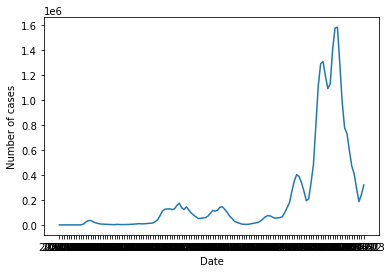

In [5]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.plot(DEU_cases)

In [6]:
## Get the deaths records
DEU_deaths = DEU_df[DEU_df['indicator'] == 'deaths'][['year_week', 'weekly_count']]
DEU_deaths = DEU_deaths.set_index(['year_week'])
DEU_deaths.head()

,weekly_count
year_week,
2020-01,0.0
2020-02,0.0
2020-03,0.0
2020-04,0.0
2020-05,0.0


# Stationarity Checking

## Rolling statistics - A visual test

In [7]:
rolmean = DEU_cases.rolling(window=12).mean()
rolstd = DEU_cases.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean and Standard deviation\n')

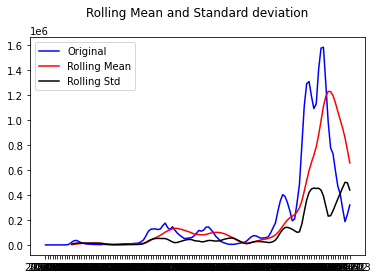

In [8]:
plt.plot(DEU_cases, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean and Standard deviation\n')

The mean and standard deviation are not stationary. So, the time seires is not stationary.

## Dickey Fuller test

In [9]:
dftest = adfuller(DEU_cases['weekly_count'], autolag='AIC')

print('Test Statistic: %f' % dftest[0])

print('p-value: %f' % dftest[1])

print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

if dftest[0] < dftest[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

Test Statistic: -1.988680
p-value: 0.291558
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Failed to Reject Ho - Time Series is Non-Stationary


## Forecasting with ARIMA model

C:\Users\vira.liubchenko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\vira.liubchenko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\vira.liubchenko\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                               SARIMAX Results                                
Dep. Variable:           weekly_count   No. Observations:                  128
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1549.328
Date:                Thu, 03 Nov 2022   AIC                           3104.655
Time:                        17:47:58   BIC                           3113.164
Sample:                             0   HQIC                          3108.112
                                - 128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0944      0.091      1.039      0.299      -0.084       0.273
ma.L1          0.3369      0.104      3.250      0.001       0.134       0.540
sigma2      3.022e+09   4.07e-11   7.43e+19      0.0

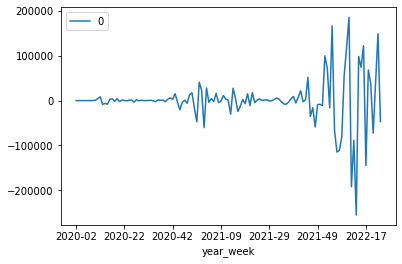

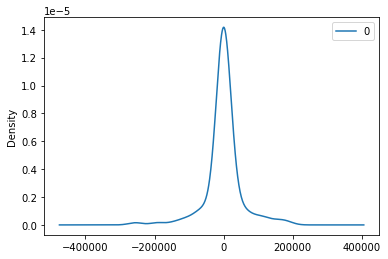

                   0
count     127.000000
mean      325.092072
std     52881.812617
min   -254980.478329
25%     -5697.097913
50%       205.397259
75%      4809.801059
max    185518.010453


In [10]:
# ARIMA model with (1,2,1)
model = ARIMA(DEU_cases, order=(1,2,1))

# fit model
result_ARIMA = model.fit()

# summary of fit model
print(result_ARIMA.summary())

# line plot of residuals
residuals = pd.DataFrame(result_ARIMA.resid)
residuals = residuals.drop(residuals.index[0])
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [11]:
predictions_ARIMA_diff = pd.Series(result_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

year_week
2020-01    0.000000
2020-02    2.377591
2020-03   -1.975104
2020-04    0.758451
2020-05    2.175779
dtype: float64

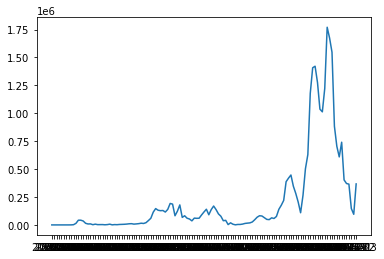

In [12]:
predictions = predictions_ARIMA_diff.drop(predictions_ARIMA_diff.index[0])
plt.plot(predictions)